In [1]:
%pylab
%matplotlib inline
import matplotlib.colors as colors
import matplotlib.pyplot as plt
import matplotlib.cm as cmx
import tensorflow as tf
import numpy as np
from IPython.display import clear_output

Using matplotlib backend: Qt4Agg
Populating the interactive namespace from numpy and matplotlib


In [2]:
plt.style.use('ggplot')
from libs.utils import montage
from libs import gif

In [3]:
from libs.datasets import MNIST

In [4]:
ds = MNIST()

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


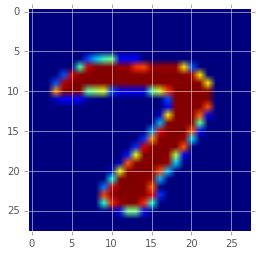

In [5]:
plt.imshow(ds.X[0].reshape(28,28))

(-0.5, 290.5, 290.5, -0.5)

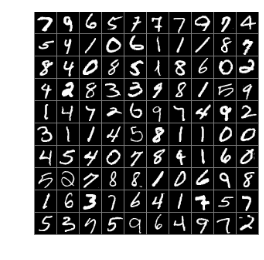

In [6]:
# Get first 1000 or whatever no. of images from the dataset and draw them in the form of montage 
imgs = ds.X[:100].reshape(-1, 28, 28)
plt.imshow(montage(imgs), cmap='gray')
plt.axis('off')

In [7]:
# FULLY CONNECTED AUTO-ENCODERS
# you can check for std deviation and mean of the images, 
# we will use autoencoder to try and encode every possible deviation in the image.
#we use fully connected networks which progressively becomes smaller and smaller
dimensions = [512,256,128,64]
n_features = ds.X.shape[1]   #Because we are considering each pixel of image to be neuron i.e. 784
X = tf.placeholder(tf.float32, [None, n_features])

In [8]:
# let's first copy our X placeholder to the name current_input
current_input = X
n_input = n_features

# We're going to keep every matrix we create so let's create a list to hold them all
Ws = []

# We'll create a for loop to create each layer:
for layer_i, n_output in enumerate(dimensions):

    # just like in the last session,
    # we'll use a variable scope to help encapsulate our variables
    # This will simply prefix all the variables made in this scope
    # with the name we give it.
    with tf.variable_scope("encoder/layer/{}".format(layer_i)):

        # Create a weight matrix which will increasingly reduce
        # down the amount of information in the input by performing
        # a matrix multiplication
        W = tf.get_variable(
            name='W',
            shape=[n_input, n_output],
            initializer=tf.random_normal_initializer(mean=0.0, stddev=0.02))

        # Now we'll multiply our input by our newly created W matrix
        # and add the bias
        h = tf.matmul(current_input, W)

        # And then use a relu activation function on its output
        current_input = tf.nn.relu(h)

        # Finally we'll store the weight matrix so we can build the decoder.
        Ws.append(W)

        # We'll also replace n_input with the current n_output, so that on the
        # next iteration, our new number inputs will be correct.
        n_input = n_output

In [9]:
# We'll first reverse the order of our weight matrices
Ws = Ws[::-1]

# then reverse the order of our dimensions
# appending the last layers number of inputs.
dimensions = dimensions[::-1][1:] + [ds.X.shape[1]]
print(dimensions)

[128, 256, 512, 784]


In [10]:
# DECODER
for layer_i, n_output in enumerate(dimensions):
    # we'll use a variable scope again to help encapsulate our variables
    # This will simply prefix all the variables made in this scope
    # with the name we give it.
    with tf.variable_scope("decoder/layer/{}".format(layer_i)):

        # Now we'll grab the weight matrix we created before and transpose it
        # So a 3072 x 784 matrix would become 784 x 3072
        # or a 256 x 64 matrix, would become 64 x 256
        W = tf.transpose(Ws[layer_i])

        # Now we'll multiply our input by our transposed W matrix
        h = tf.matmul(current_input, W)

        # And then use a relu activation function on its output
        current_input = tf.nn.relu(h)

        # We'll also replace n_input with the current n_output, so that on the
        # next iteration, our new number inputs will be correct.
        n_input = n_output

In [11]:
Y = current_input
mean_img = np.mean(ds.X, axis=0)

In [12]:
# TRAINING
# We'll first measure the average difference across every pixel (neuron)
cost = tf.reduce_mean(tf.squared_difference(X, Y), 1)
print(cost.get_shape())
# MEAN across batches
cost = tf.reduce_mean(cost)
learning_rate = 0.001
optimizer = tf.train.AdamOptimizer(learning_rate).minimize(cost)

(?,)


In [13]:
# %%
# We create a session to use the graph
sess = tf.Session()
sess.run(tf.initialize_all_variables())

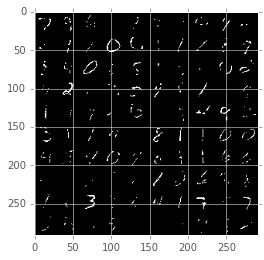

(4, 0.031043025)


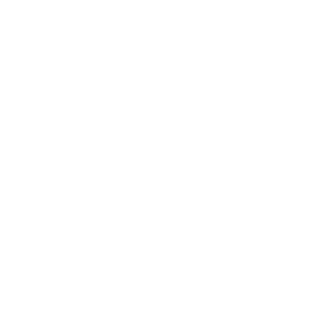

In [15]:
# Some parameters for training
batch_size = 100
n_epochs = 5

# We'll try to reconstruct the same first 100 images and show how
# The network does over the course of training.
examples = ds.X[:100]

# We'll store the reconstructions in a list
imgs = []
#fig, ax = plt.subplots(1, 1)
for epoch_i in range(n_epochs):
    for batch_X, _ in ds.train.next_batch():
        sess.run(optimizer, feed_dict={X: batch_X - mean_img})
    recon = sess.run(Y, feed_dict={X: examples - mean_img})
    recon = np.clip((recon + mean_img).reshape((-1, 28, 28)), 0, 255)
    img_i = montage(recon).astype(np.uint8)
    imgs.append(img_i)
    clear_output()
    plt.imshow(img_i, cmap='gray')
    plt.show()
    #fig.canvas.draw()
    print(epoch_i, sess.run(cost, feed_dict={X: batch_X - mean_img}))

# FOR GIF you have to send list of images 
gif.build_gif(imgs, saveto='ae.gif', cmap='gray')

In [17]:
import IPython.display as ipyd
ipyd.Image(url='ae.gif?{}'.format(np.random.rand()),
           height=500, width=500)